#### 0. Импорт библиотек

In [27]:
# from google.colab import drive
# drive.mount('/content/drive')

In [28]:
#!pip install torchutils

In [29]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T
from torch.nn import functional as F
from torchvision.models import resnet50, ResNet50_Weights, resnet18, ResNet18_Weights
from torch.optim.lr_scheduler import StepLR

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import numpy as np
import pandas as pd
import torchutils as tu
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import multiprocessing as mp

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# if __name__ == "__main__":
#     mp.set_start_method("spawn", force=True)
print(device)

cuda


#### 1. Импорт датасета

In [31]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/blood-cells")

print("Path to dataset files:", path)

Path to dataset files: /home/dmitry/.cache/kagglehub/datasets/paultimothymooney/blood-cells/versions/6


In [32]:
# определяем пути к данным
# train_path = '../../datasets/blood_cells/dataset2-master/dataset2-master/images/TRAIN'
# test_path = '../../datasets/blood_cells/dataset2-master/dataset2-master/images/TEST'

train_path = "/home/dmitry/.cache/kagglehub/datasets/paultimothymooney/blood-cells/versions/6/dataset2-master/dataset2-master/images/TRAIN"
test_path = "/home/dmitry/.cache/kagglehub/datasets/paultimothymooney/blood-cells/versions/6/dataset2-master/dataset2-master/images/TEST"

In [33]:
# !ls {test_path}

In [34]:
# Трансформации для тренировочных данных
train_transforms = T.Compose(
    [
        T.Resize((224, 224)),
        T.RandomResizedCrop(224, scale=(0.8, 1.0)),
        T.RandomHorizontalFlip(),
        T.RandomVerticalFlip(),
        T.RandomRotation(10),
        T.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        T.ToTensor(),  # конвертация в тензор
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        T.RandomErasing(p=0.2),
    ]
)

# Трансформации для тестовых/валидационных данных
test_transforms = T.Compose(
    [
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

# Создание датасетов
train_dataset = datasets.ImageFolder(root=train_path, transform=train_transforms)
test_dataset = datasets.ImageFolder(root=test_path, transform=test_transforms)
class_names = train_dataset.classes
num_classes = len(class_names)
# test_dataset.classes = class_names
# Создание загрузчиков данных
batch_size = 128

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True if device.type == "cuda" else False,
)  # , num_workers=4
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True if device.type == "cuda" else False,
)  # , num_workers=4
print(train_dataset.classes)
print(test_dataset.classes)

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


In [35]:
# Получение информации о классах

print(f"Классы: {class_names}")
print(f"Количество классов: {num_classes}")
print(f"Размер тренировочного датасета: {len(train_dataset)}")
print(f"Размер тестового датасета: {len(test_dataset)}")

Классы: ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
Количество классов: 4
Размер тренировочного датасета: 9957
Размер тестового датасета: 2487


In [36]:
# pd.read_csv('../../datasets/blood_cells/dataset2-master/dataset2-master/labels.csv', index_col=False)

#### 2. Загрузка предобученной модели

In [37]:
weights = ResNet50_Weights.IMAGENET1K_V2
model = resnet50(weights=weights)

In [38]:
# weights = ResNet18_Weights.IMAGENET1K_V1
# model = resnet18(weights=weights)

In [39]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [40]:
# Посмотрим оригинальную архитектуру
print("\nОригинальная архитектура последнего слоя:")
print(f"model.fc: {model.fc}")
print(f"Входные features: {model.fc.in_features}")
print(f"Выходные features: {model.fc.out_features} (1000 классов)")


Оригинальная архитектура последнего слоя:
model.fc: Linear(in_features=2048, out_features=1000, bias=True)
Входные features: 2048
Выходные features: 1000 (1000 классов)


In [41]:
# Заменим параметры выходного слоя согласно нашей задаче
model.fc = nn.Sequential(
    nn.Linear(2048, 256),  # Дополнительный FC слой с 256 нейронами
    nn.ReLU(inplace=True),  # Активизация ReLU
    nn.Dropout(p=0.5),  # Dropout для регуляризации (50%)
    nn.Linear(256, num_classes),  # Выходной слой с 4 классами
)
print(f"Новая архитектура model.fc: {model.fc}")

Новая архитектура model.fc: Sequential(
  (0): Linear(in_features=2048, out_features=256, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=256, out_features=4, bias=True)
)


In [42]:
# 1. замораживаем все веса в модели:
# Проходим по всем параметрам модели (веса, смещения в слоях) и запрещаем вычисление градиентов т.е. во время обучения они не будут обновляться
for param in model.parameters():
    param.requires_grad = False

# 2. Теперь включаем обучение только для последнего линейного слоя (fc)

# Разрешаем обновлять его веса (матрица W)
model.fc[0].weight.requires_grad = True
# Разрешаем обновлять его смещение (bias)
model.fc[0].bias.requires_grad = True

# Разрешаем обновлять его веса (матрица W)
model.fc[3].weight.requires_grad = True
# Разрешаем обновлять его смещение (bias)
model.fc[3].bias.requires_grad = True

for param in model.layer4.parameters():  # и веса и смещения
    param.requires_grad = True

# for param in model.fc.parameters(): # и веса и смещения
#     param.requires_grad = True

# model.to(device)

model.to(device)
# for p in model.parameters():
#     p.requires_grad = True

# backbone_params = [p for n, p in model.named_parameters() if not n.startswith("fc")]
# head_params = list(model.fc.parameters())

# optimizer = torch.optim.AdamW(
#     [
#         {"params": backbone_params, "lr": 1e-5, "weight_decay": 1e-3},
#         {"params": head_params, "lr": 1e-4, "weight_decay": 1e-3},
#     ]
# )

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### 3. Обучение модели

In [43]:
# ВАЖНО! Для ускорения укажем ТОЛЬКО те параметры, которые требуют градиентов
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=0.00001, weight_decay=1e-3
)
criterion = nn.CrossEntropyLoss()

In [44]:
def train_model(
    model, train_loader, test_loader, criterion, optimizer, num_epochs=10, device="cuda"
):
    """
    Функция для обучения модели с записью предсказаний и метрик
    """
    model = model.to(device)

    # Списки для хранения всех предсказаний и меток
    all_train_preds = []
    all_train_labels = []
    all_test_preds = []
    all_test_labels = []

    # История обучения
    history = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
        "precision": [],
        "recall": [],
        "f1": [],
    }

    for epoch in range(num_epochs):
        # Режим обучения
        model.train()
        running_loss = 0.0
        epoch_train_preds = []
        epoch_train_labels = []

        # Прогресс-бар для тренировочной эпохи
        train_pbar = tqdm(
            train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False
        )

        for inputs, labels in train_pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Обнуление градиентов
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Сохранение статистики
            running_loss += loss.item() * inputs.size(0)

            # Сохранение предсказаний и меток
            _, preds = torch.max(outputs, 1)
            epoch_train_preds.extend(preds.cpu().numpy())
            epoch_train_labels.extend(labels.cpu().numpy())

            # Обновление прогресс-бара
            train_pbar.set_postfix({"Loss": loss.item()})

        # Сохранение тренировочных предсказаний
        all_train_preds.extend(epoch_train_preds)
        all_train_labels.extend(epoch_train_labels)

        # Расчет метрик для тренировочных данных
        train_loss = running_loss / len(train_loader.dataset)
        train_acc = accuracy_score(epoch_train_labels, epoch_train_preds)

        # Режим валидации
        model.eval()
        test_loss = 0.0
        epoch_test_preds = []
        epoch_test_labels = []

        with torch.no_grad():
            # Прогресс-бар для тестовой эпохи
            test_pbar = tqdm(
                test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Test]", leave=False
            )

            for inputs, labels in test_pbar:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                epoch_test_preds.extend(preds.cpu().numpy())
                epoch_test_labels.extend(labels.cpu().numpy())

                test_pbar.set_postfix({"Loss": loss.item()})

        # Сохранение тестовых предсказаний
        all_test_preds.extend(epoch_test_preds)
        all_test_labels.extend(epoch_test_labels)

        # Расчет метрик для тестовых данных
        test_loss = test_loss / len(test_loader.dataset)
        test_acc = accuracy_score(epoch_test_labels, epoch_test_preds)
        prec = precision_score(
            epoch_test_labels, epoch_test_preds, average="weighted", zero_division=0
        )
        rec = recall_score(
            epoch_test_labels, epoch_test_preds, average="weighted", zero_division=0
        )
        f1_val = f1_score(
            epoch_test_labels, epoch_test_preds, average="weighted", zero_division=0
        )

        # Сохранение истории
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["test_loss"].append(test_loss)
        history["test_acc"].append(test_acc)
        history["precision"].append(prec)
        history["recall"].append(rec)
        history["f1"].append(f1_val)

        # Вывод статистики
        print(f"Epoch {epoch+1}/{num_epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
        print(f"Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1_val:.4f}")
        print("-" * 50)

    return (
        model,
        history,
        all_test_preds,
        all_test_labels,
        epoch_test_preds,
        epoch_test_labels,
    )

In [45]:
# Обучение модели
num_epochs = 10
print("начало обучения...")

model, history, all_preds, all_labels, last_preds, last_labels = train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs,
    device=device,
)

начало обучения...


Epoch 1/10:
Train Loss: 1.3802, Train Acc: 0.2896
Test Loss: 1.3786, Test Acc: 0.2786
Precision: 0.3976, Recall: 0.2786, F1: 0.1653
--------------------------------------------------


Epoch 2/10:
Train Loss: 1.3296, Train Acc: 0.4357
Test Loss: 1.3058, Test Acc: 0.5094
Precision: 0.4956, Recall: 0.5094, F1: 0.4734
--------------------------------------------------


Epoch 3/10:
Train Loss: 1.0848, Train Acc: 0.6002
Test Loss: 0.9857, Test Acc: 0.6618
Precision: 0.6881, Recall: 0.6618, F1: 0.6461
--------------------------------------------------


Epoch 4/10:
Train Loss: 0.7301, Train Acc: 0.7457
Test Loss: 0.7328, Test Acc: 0.7929
Precision: 0.8205, Recall: 0.7929, F1: 0.7913
--------------------------------------------------


Epoch 5/10:
Train Loss: 0.5003, Train Acc: 0.8246
Test Loss: 0.5984, Test Acc: 0.8158
Precision: 0.8398, Recall: 0.8158, F1: 0.8146
--------------------------------------------------


Epoch 6/10:
Train Loss: 0.3838, Train Acc: 0.8626
Test Loss: 0.5638, Test Acc: 0.8170
Precision: 0.8439, Recall: 0.8170, F1: 0.8172
--------------------------------------------------


Epoch 7/10:
Train Loss: 0.3043, Train Acc: 0.8886
Test Loss: 0.5701, Test Acc: 0.8106
Precision: 0.8388, Recall: 0.8106, F1: 0.8115
--------------------------------------------------


Epoch 8/10:
Train Loss: 0.2524, Train Acc: 0.9113
Test Loss: 0.5355, Test Acc: 0.8227
Precision: 0.8462, Recall: 0.8227, F1: 0.8242
--------------------------------------------------


Epoch 9/10:
Train Loss: 0.2216, Train Acc: 0.9202
Test Loss: 0.5286, Test Acc: 0.8323
Precision: 0.8552, Recall: 0.8323, F1: 0.8339
--------------------------------------------------


Epoch 10/10:
Train Loss: 0.1917, Train Acc: 0.9316
Test Loss: 0.5586, Test Acc: 0.8291
Precision: 0.8568, Recall: 0.8291, F1: 0.8307
--------------------------------------------------


In [46]:
history_df = pd.DataFrame(history)
history_df.to_csv("results/metrics.csv", index=False)

In [47]:
# Сохранять веса модели
torch.save(
    model.state_dict(),
    "results/model_resnet18_bloodcells.pth",
)
# # Сохранять индекс классов
# import json

# with open("results/bloodcells/class_to_idx.json", "w") as f:
#     json.dump(train_dataset.class_to_idx, f)

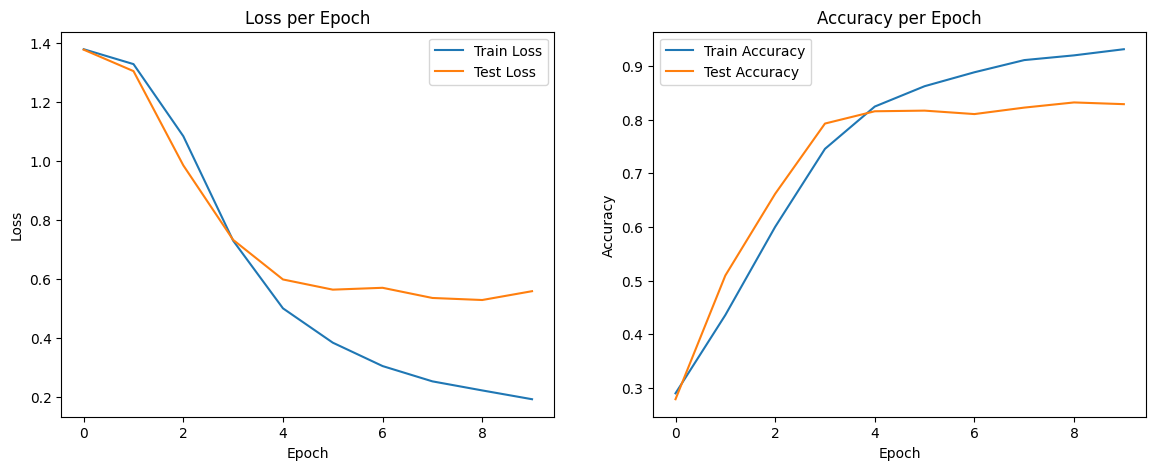

In [48]:
# Кривые обучения: Loss и Accuracy
fig = plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["test_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["test_acc"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()
plt.show()
fig.savefig("results/loss_acc.png")

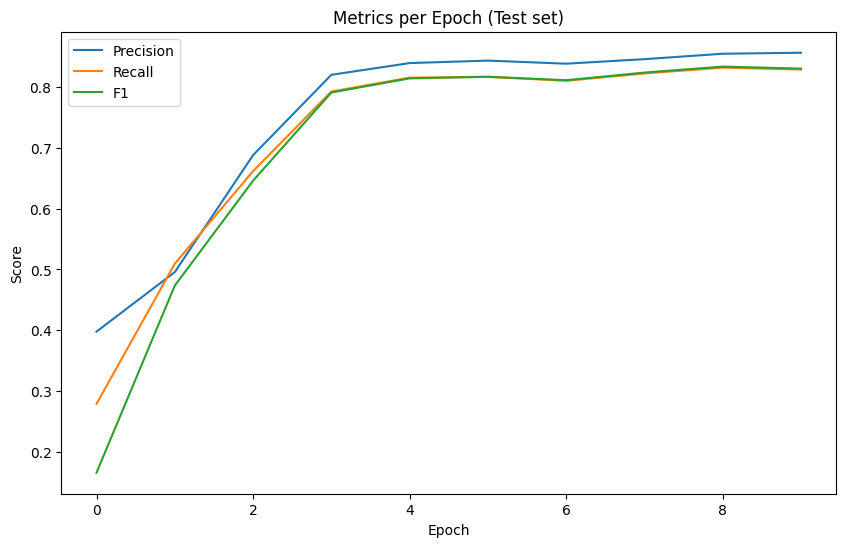

In [49]:
# Кривые метрик: Precision, Recall, F1
fig1 = plt.figure(figsize=(10, 6))
plt.plot(history["precision"], label="Precision")
plt.plot(history["recall"], label="Recall")
plt.plot(history["f1"], label="F1")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Metrics per Epoch (Test set)")
plt.legend()
plt.show()
fig1.savefig("results/metrics_test.png")

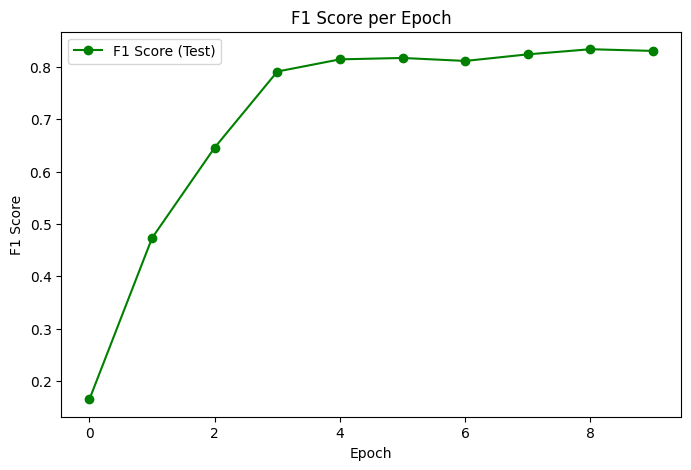

In [50]:
fig2 = plt.figure(figsize=(8, 5))
plt.plot(history["f1"], marker="o", color="green", label="F1 Score (Test)")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("F1 Score per Epoch")
plt.legend()
plt.show()
fig2.savefig("results/f1_test.png")

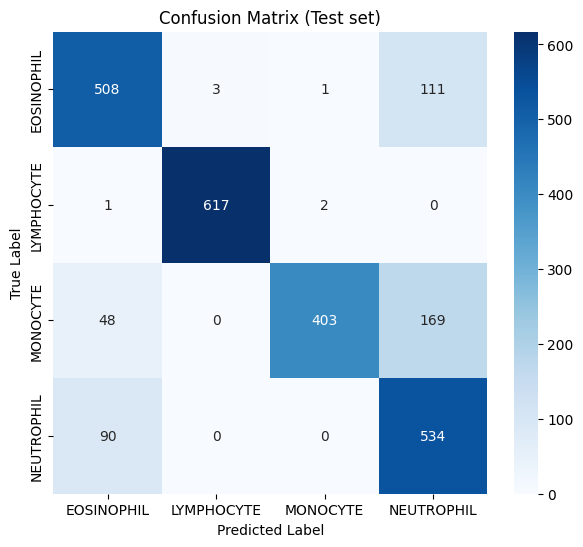

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion matrix по итогам предсказаний на тесте
cm = confusion_matrix(last_labels, last_preds)
fig3 = plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test set)")
plt.show()
fig3.savefig("results/confusion_matrix.png")

In [52]:
cm_percent = (
    cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100
)  # проценты по строкам (True Label)

for idx, classname in enumerate(class_names):
    print(
        f"{classname}: Верно классифицировано {cm_percent[idx, idx]:.2f}%, ошибки: {100-cm_percent[idx, idx]:.2f}%"
    )

EOSINOPHIL: Верно классифицировано 81.54%, ошибки: 18.46%
LYMPHOCYTE: Верно классифицировано 99.52%, ошибки: 0.48%
MONOCYTE: Верно классифицировано 65.00%, ошибки: 35.00%
NEUTROPHIL: Верно классифицировано 85.58%, ошибки: 14.42%
